# 1:1 with 100 of each class

In [1]:
import pandas as pd
from sktime.classification.hybrid import HIVECOTEV2
import numpy as np
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
import tensorflow as tf
from sklearn.metrics import precision_recall_fscore_support
from sklearn.neighbors import KNeighborsClassifier
import time
from sklearn.model_selection import cross_validate
from sklearn.metrics import f1_score, roc_auc_score
from sklearn.metrics import RocCurveDisplay, ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt
import csv

#depression tweets
dt = pd.read_csv("data/depression_tweets.tsv", sep="\t", index_col="tweet_id", parse_dates=[2])
#dt["created_at"] = pd.to_datetime(dt["created_at"])
n_depression = 100
print(n_depression)

#sample tweets
st = pd.read_csv("data/sample_tweets.tsv", sep="\t", index_col="tweet_id", parse_dates=[2])
#st["created_at"] = pd.to_datetime(st["created_at"])

#filtered users
fu = pd.read_csv('filtered_user_lists.csv')
fu_tbt = pd.read_csv('filtered_user_lists_only_tpd_tbt.csv')
fu_maxtime = pd.read_csv('filtered_user_lists_only_tpd_maxtime.csv')
#tpd pairs
tpd_pairs = pd.read_csv('pairs_tpd_users.csv')
filtered_users = pd.concat([fu, fu_tbt, fu_maxtime], ignore_index=True)
j = 948
current = filtered_users.iloc[j]
print(current)
current_user_list = eval(current.user_list)

#get distribution of current filtered list
avg_dist = {}
current_tpds = tpd_pairs[tpd_pairs['user id'].isin(set(current_user_list))]
for avg in current_tpds['tweets per day'].unique():
    tmp_dist = float((current_tpds[current_tpds['tweets per day'] == avg].count() / len(current_tpds)).iloc[0])
    avg_dist.update({str(avg): str(tmp_dist)})

dist_df = pd.DataFrame(avg_dist.items(), columns=['tweets per day', 'percentage'])
dist_df = dist_df.astype({'tweets per day': 'int32'})
dist_df = dist_df.astype({'percentage': 'float'})
dist_df = dist_df.sort_values(by=['tweets per day'])

#downsample current user list based on distribution
current_samples = pd.DataFrame(columns=['user id', 'tweets per day'])
for tpd in current_tpds['tweets per day'].unique():
    tmp_df = current_tpds[current_tpds['tweets per day'] == tpd]
    frac = float(dist_df.loc[dist_df['tweets per day'] == tpd]['percentage'].iloc[0])
    if int(n_depression * frac) < len(tmp_df):
        sampled_tmp_df = tmp_df.sample(n=int(n_depression * frac), random_state=42)
    else:
        sampled_tmp_df = tmp_df
    current_samples = current_samples._append(sampled_tmp_df, ignore_index=True)

present_tpd = current_samples['tweets per day'].unique().tolist()
all_tpd = dist_df['tweets per day'].unique().tolist()
diff_tpd = list(set(present_tpd).symmetric_difference(set(all_tpd)))
dist_df = dist_df.sort_values('percentage', ascending=False)  #sort percentages here

#fill up remaining spots with random users from rs cohort not yet present in sampled users starting with most occuring tpd class in filtered user list (all tpd not already in sampled list)
needed_tpd = []
counter = n_depression - len(current_samples['user id'].unique())
if counter > 0:
    for tpd in dist_df['tweets per day'].unique():
        if tpd in diff_tpd and counter > 0:
            tmp_df = current_tpds[current_tpds['tweets per day'] == tpd]
            #make sure to not sample a user again
            sampled_tmp_df = tmp_df.sample(n=1, random_state=42)
            if current_samples['user id'].eq(sampled_tmp_df['user id'].tolist()[0]).any():
                unique = False
                stop = len(current_tpds['user id'].unique())
                while (not unique) or (stop > 0):
                    sampled_tmp_df = tmp_df.sample(n=1, random_state=42)
                    if not current_samples['user id'].eq(sampled_tmp_df['user id'].tolist()[0]).any():
                        unique = True
                    stop = stop - 1

            current_samples = current_samples._append(sampled_tmp_df, ignore_index=True)
            counter = counter - 1
print(counter)
print(len(current_samples['user id'].unique()))
#if still space left, fill again, this time not caring if tpd is already in final list with samples from all users in rs cohort, with disregard to filtered users

#while counter > 0:
#    for tpd in tpd_pairs['tweets per day'].unique():
#        if counter > 0:
#            tmp_df = tpd_pairs[tpd_pairs['tweets per day']==tpd]
#            #make sure to not sample a user again
#            sampled_tmp_df = tmp_df.sample(n=1, random_state=42)
#            if current_samples['user id'].eq(sampled_tmp_df['user id'].tolist()[0]).any():
#                unique = False
#                stop = len(tpd_pairs['user id'].unique())
#                while (not unique) or (stop>0):
#                    #print('not unique')
#                    sampled_tmp_df = tmp_df.sample(n=1)
#                    if not current_samples['user id'].eq(sampled_tmp_df['user id'].tolist()[0]).any():
#                        unique = True
#                    stop = stop - 1
#
#            current_samples = current_samples._append(sampled_tmp_df, ignore_index=True)
#            counter = counter - 1

current_user_list = list(set(st.user_id.unique()).symmetric_difference(set(current_samples['user id'].unique())))

avg_dist = {}
current_tpds = tpd_pairs[tpd_pairs['user id'].isin(set(current_user_list))]
for avg in current_tpds['tweets per day'].unique():
    tmp_dist = float((current_tpds[current_tpds['tweets per day'] == avg].count() / len(current_tpds)).iloc[0])
    avg_dist.update({str(avg): str(tmp_dist)})

dist_df = pd.DataFrame(avg_dist.items(), columns=['tweets per day', 'percentage'])
dist_df = dist_df.astype({'tweets per day': 'int32'})
dist_df = dist_df.astype({'percentage': 'float'})
dist_df = dist_df.sort_values(by=['tweets per day'])

for tpd in current_tpds['tweets per day'].unique():
    tmp_df = current_tpds[current_tpds['tweets per day'] == tpd]
    frac = float(dist_df.loc[dist_df['tweets per day'] == tpd]['percentage'].iloc[0])
    if int(n_depression * frac) < len(tmp_df):
        sampled_tmp_df = tmp_df.sample(n=int(n_depression * frac), random_state=42)
    else:
        sampled_tmp_df = tmp_df
    current_samples = current_samples._append(sampled_tmp_df, ignore_index=True)

present_tpd = current_samples['tweets per day'].unique().tolist()
all_tpd = dist_df['tweets per day'].unique().tolist()
diff_tpd = list(set(present_tpd).symmetric_difference(set(all_tpd)))
dist_df = dist_df.sort_values('percentage', ascending=False)  #sort percentages here

needed_tpd = []
counter = n_depression - len(current_samples['user id'].unique())
while counter > 0:
    for tpd in dist_df['tweets per day'].unique():
        if tpd in diff_tpd and counter > 0:
            tmp_df = current_tpds[current_tpds['tweets per day'] == tpd]
            #make sure to not sample a user again
            sampled_tmp_df = tmp_df.sample(n=1, random_state=42)
            if current_samples['user id'].eq(sampled_tmp_df['user id'].tolist()[0]).any():
                unique = False
                stop = len(current_tpds['user id'].unique())
                while (not unique) or (stop > 0):
                    sampled_tmp_df = tmp_df.sample(n=1, random_state=42)
                    if not current_samples['user id'].eq(sampled_tmp_df['user id'].tolist()[0]).any():
                        unique = True
                    stop = stop - 1

            current_samples = current_samples._append(sampled_tmp_df, ignore_index=True)
            counter = counter - 1

print(len(current_samples['user id'].unique()))
# create dataset as df list with uniform dfs
data = {}
labels = []
data_list = []

d_user_list = list(dt.user_id.unique()[:100]) # just take first 100 depressed users

#assamble data
for user in d_user_list:
    tmp = dt[dt['user_id'] == user]
    tweet_list = tmp['created_at'].map(lambda datetime: int(round(datetime.timestamp()))).to_numpy()
    data.update({''+user+'': tweet_list})
    labels.append(1)

for user in current_samples['user id'].unique():
    tmp = st[st['user_id'] == user]
    tweet_list = tmp['created_at'].map(lambda datetime: int(round(datetime.timestamp()))).to_numpy()
    data.update({''+user+'': tweet_list})
    labels.append(0)

df_data = pd.DataFrame(dict([(key, pd.Series(value)) for key, value in data.items()]))
df_labels = pd.DataFrame(labels)
#----------------------------------------------------
from sklearn.model_selection import train_test_split

df_data = df_data.transpose()
df_data.index = range(0, len(df_data.index))
df_data.sort_index()
df_data = df_data.fillna(0)
X_train, X_test, y_train, y_test = train_test_split(df_data, df_labels, test_size=0.2)
#---------------------------------------------------------------------------------

100
Unnamed: 0                                                       108
min_tpd                                                           10
max_days_bt                                                        1
min_days_active                                                   30
user_list          ['uR0011', 'uR0014', 'uR0015', 'uR0022', 'uR00...
Name: 948, dtype: object
0
100
182


In [2]:
from sklearn.metrics import PrecisionRecallDisplay
scoring = ['f1', 'precision', 'recall', 'accuracy', 'roc_auc', 'average_precision']

In [35]:
y_train.to_numpy().squeeze()

array([0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1,
       1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0,
       1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1,
       0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0,
       1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0,
       0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0,
       1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0,
       1, 1, 0, 0, 1], dtype=int64)

C:\Users\99mor\PycharmProjects\phaseUnlocking\venv\lib\site-packages\sktime\classification\interval_based\_drcif.py:525: RuntimeWarning: overflow encountered in multiply
  transformed_x = transformed_x.round(8)
C:\Users\99mor\PycharmProjects\phaseUnlocking\venv\lib\site-packages\sktime\classification\interval_based\_drcif.py:525: RuntimeWarning: overflow encountered in multiply
  transformed_x = transformed_x.round(8)
C:\Users\99mor\PycharmProjects\phaseUnlocking\venv\lib\site-packages\sktime\classification\interval_based\_drcif.py:525: RuntimeWarning: overflow encountered in multiply
  transformed_x = transformed_x.round(8)
C:\Users\99mor\PycharmProjects\phaseUnlocking\venv\lib\site-packages\sktime\classification\interval_based\_drcif.py:525: RuntimeWarning: overflow encountered in multiply
  transformed_x = transformed_x.round(8)
C:\Users\99mor\PycharmProjects\phaseUnlocking\venv\lib\site-packages\sktime\classification\interval_based\_drcif.py:525: RuntimeWarning: overflow encountere

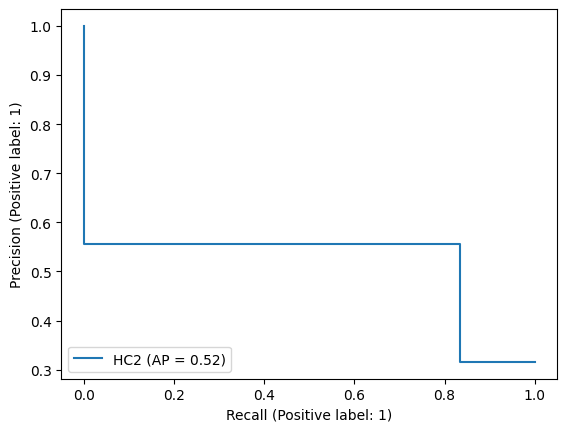

In [3]:
from sktime.classification.hybrid import HIVECOTEV2
hc2 = HIVECOTEV2()

start = time.perf_counter()

hc2.fit(X_train.to_numpy(), y_train.to_numpy().squeeze())

end = time.perf_counter()
train_time = end - start


score = hc2.score(X_test.to_numpy(), y_test.to_numpy().squeeze())


start = time.perf_counter()
y_pred = hc2.predict(X_test.to_numpy())
end = time.perf_counter()
test_time = end - start

ConfusionMatrixDisplay.from_predictions(y_test, y_pred, normalize='all')
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, normalize='pred')
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, normalize='true')
plt.show()
RocCurveDisplay.from_predictions(y_test, y_pred, name='HC2')
plt.show()
PrecisionRecallDisplay.from_predictions(y_test, y_pred, name='HC2')
plt.savefig('.\cv_new_figs\hc2_pr.png')
plt.show()

precision, recall, f1, _ =precision_recall_fscore_support(y_test, y_pred, average='binary', pos_label=1)
print('HC2 1:1')
print(score)
print(precision)
print(recall)
print(f1)
print(train_time)
print(test_time)

In [4]:
from sktime.classification.hybrid import HIVECOTEV2

hc2 = HIVECOTEV2()

hc2_scores = cross_validate(hc2, X_train.to_numpy(), y_train.to_numpy().squeeze(), scoring=scoring, cv=5, return_train_score=True)

with open('.\cv_pr\cv_hc2_scores.csv', 'w') as csvfile:
    writer = csv.DictWriter(csvfile, fieldnames = hc2_scores.keys())
    writer.writeheader()
    writer.writerow(hc2_scores)

C:\Users\99mor\PycharmProjects\phaseUnlocking\venv\lib\site-packages\sktime\classification\interval_based\_drcif.py:525: RuntimeWarning: overflow encountered in multiply
  transformed_x = transformed_x.round(8)
C:\Users\99mor\PycharmProjects\phaseUnlocking\venv\lib\site-packages\sktime\classification\interval_based\_drcif.py:525: RuntimeWarning: overflow encountered in multiply
  transformed_x = transformed_x.round(8)
C:\Users\99mor\PycharmProjects\phaseUnlocking\venv\lib\site-packages\sktime\classification\interval_based\_drcif.py:525: RuntimeWarning: overflow encountered in multiply
  transformed_x = transformed_x.round(8)
C:\Users\99mor\PycharmProjects\phaseUnlocking\venv\lib\site-packages\sktime\classification\interval_based\_drcif.py:525: RuntimeWarning: overflow encountered in multiply
  transformed_x = transformed_x.round(8)
C:\Users\99mor\PycharmProjects\phaseUnlocking\venv\lib\site-packages\sktime\classification\interval_based\_drcif.py:525: RuntimeWarning: overflow encountere

# 1:2 ratio with 100 depressed individuals

In [1]:
import pandas as pd
from sktime.classification.hybrid import HIVECOTEV2
import numpy as np
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
import tensorflow as tf
from sklearn.metrics import precision_recall_fscore_support
from sklearn.neighbors import KNeighborsClassifier
import time
from sklearn.model_selection import cross_validate
from sklearn.metrics import f1_score, roc_auc_score
from sklearn.metrics import RocCurveDisplay, ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt
import csv

#depression tweets
dt = pd.read_csv("data/depression_tweets.tsv", sep="\t", index_col="tweet_id", parse_dates=[2])
#dt["created_at"] = pd.to_datetime(dt["created_at"])
n_depression = 200
print(n_depression)

#sample tweets
st = pd.read_csv("data/sample_tweets.tsv", sep="\t", index_col="tweet_id", parse_dates=[2])
#st["created_at"] = pd.to_datetime(st["created_at"])

#filtered users
fu = pd.read_csv('filtered_user_lists.csv')
fu_tbt = pd.read_csv('filtered_user_lists_only_tpd_tbt.csv')
fu_maxtime = pd.read_csv('filtered_user_lists_only_tpd_maxtime.csv')
#tpd pairs
tpd_pairs = pd.read_csv('pairs_tpd_users.csv')
filtered_users = pd.concat([fu, fu_tbt, fu_maxtime], ignore_index=True)
j = 948
current = filtered_users.iloc[j]
print(current)
current_user_list = eval(current.user_list)

#get distribution of current filtered list
avg_dist = {}
current_tpds = tpd_pairs[tpd_pairs['user id'].isin(set(current_user_list))]
for avg in current_tpds['tweets per day'].unique():
    tmp_dist = float((current_tpds[current_tpds['tweets per day'] == avg].count() / len(current_tpds)).iloc[0])
    avg_dist.update({str(avg): str(tmp_dist)})

dist_df = pd.DataFrame(avg_dist.items(), columns=['tweets per day', 'percentage'])
dist_df = dist_df.astype({'tweets per day': 'int32'})
dist_df = dist_df.astype({'percentage': 'float'})
dist_df = dist_df.sort_values(by=['tweets per day'])

#downsample current user list based on distribution
current_samples = pd.DataFrame(columns=['user id', 'tweets per day'])
for tpd in current_tpds['tweets per day'].unique():
    tmp_df = current_tpds[current_tpds['tweets per day'] == tpd]
    frac = float(dist_df.loc[dist_df['tweets per day'] == tpd]['percentage'].iloc[0])
    if int(n_depression * frac) < len(tmp_df):
        sampled_tmp_df = tmp_df.sample(n=int(n_depression * frac), random_state=42)
    else:
        sampled_tmp_df = tmp_df
    current_samples = current_samples._append(sampled_tmp_df, ignore_index=True)

present_tpd = current_samples['tweets per day'].unique().tolist()
all_tpd = dist_df['tweets per day'].unique().tolist()
diff_tpd = list(set(present_tpd).symmetric_difference(set(all_tpd)))
dist_df = dist_df.sort_values('percentage', ascending=False)  #sort percentages here

#fill up remaining spots with random users from rs cohort not yet present in sampled users starting with most occuring tpd class in filtered user list (all tpd not already in sampled list)
needed_tpd = []
counter = n_depression - len(current_samples['user id'].unique())
if counter > 0:
    for tpd in dist_df['tweets per day'].unique():
        if tpd in diff_tpd and counter > 0:
            tmp_df = current_tpds[current_tpds['tweets per day'] == tpd]
            #make sure to not sample a user again
            sampled_tmp_df = tmp_df.sample(n=1, random_state=42)
            if current_samples['user id'].eq(sampled_tmp_df['user id'].tolist()[0]).any():
                unique = False
                stop = len(current_tpds['user id'].unique())
                while (not unique) or (stop > 0):
                    sampled_tmp_df = tmp_df.sample(n=1, random_state=42)
                    if not current_samples['user id'].eq(sampled_tmp_df['user id'].tolist()[0]).any():
                        unique = True
                    stop = stop - 1

            current_samples = current_samples._append(sampled_tmp_df, ignore_index=True)
            counter = counter - 1
print(counter)
print(len(current_samples['user id'].unique()))
#if still space left, fill again, this time not caring if tpd is already in final list with samples from all users in rs cohort, with disregard to filtered users

#while counter > 0:
#    for tpd in tpd_pairs['tweets per day'].unique():
#        if counter > 0:
#            tmp_df = tpd_pairs[tpd_pairs['tweets per day']==tpd]
#            #make sure to not sample a user again
#            sampled_tmp_df = tmp_df.sample(n=1, random_state=42)
#            if current_samples['user id'].eq(sampled_tmp_df['user id'].tolist()[0]).any():
#                unique = False
#                stop = len(tpd_pairs['user id'].unique())
#                while (not unique) or (stop>0):
#                    #print('not unique')
#                    sampled_tmp_df = tmp_df.sample(n=1)
#                    if not current_samples['user id'].eq(sampled_tmp_df['user id'].tolist()[0]).any():
#                        unique = True
#                    stop = stop - 1
#
#            current_samples = current_samples._append(sampled_tmp_df, ignore_index=True)
#            counter = counter - 1

current_user_list = list(set(st.user_id.unique()).symmetric_difference(set(current_samples['user id'].unique())))

avg_dist = {}
current_tpds = tpd_pairs[tpd_pairs['user id'].isin(set(current_user_list))]
for avg in current_tpds['tweets per day'].unique():
    tmp_dist = float((current_tpds[current_tpds['tweets per day'] == avg].count() / len(current_tpds)).iloc[0])
    avg_dist.update({str(avg): str(tmp_dist)})

dist_df = pd.DataFrame(avg_dist.items(), columns=['tweets per day', 'percentage'])
dist_df = dist_df.astype({'tweets per day': 'int32'})
dist_df = dist_df.astype({'percentage': 'float'})
dist_df = dist_df.sort_values(by=['tweets per day'])

for tpd in current_tpds['tweets per day'].unique():
    tmp_df = current_tpds[current_tpds['tweets per day'] == tpd]
    frac = float(dist_df.loc[dist_df['tweets per day'] == tpd]['percentage'].iloc[0])
    if int(n_depression * frac) < len(tmp_df):
        sampled_tmp_df = tmp_df.sample(n=int(n_depression * frac), random_state=42)
    else:
        sampled_tmp_df = tmp_df
    current_samples = current_samples._append(sampled_tmp_df, ignore_index=True)

present_tpd = current_samples['tweets per day'].unique().tolist()
all_tpd = dist_df['tweets per day'].unique().tolist()
diff_tpd = list(set(present_tpd).symmetric_difference(set(all_tpd)))
dist_df = dist_df.sort_values('percentage', ascending=False)  #sort percentages here

needed_tpd = []
counter = n_depression - len(current_samples['user id'].unique())
while counter > 0:
    for tpd in dist_df['tweets per day'].unique():
        if tpd in diff_tpd and counter > 0:
            tmp_df = current_tpds[current_tpds['tweets per day'] == tpd]
            #make sure to not sample a user again
            sampled_tmp_df = tmp_df.sample(n=1, random_state=42)
            if current_samples['user id'].eq(sampled_tmp_df['user id'].tolist()[0]).any():
                unique = False
                stop = len(current_tpds['user id'].unique())
                while (not unique) or (stop > 0):
                    sampled_tmp_df = tmp_df.sample(n=1, random_state=42)
                    if not current_samples['user id'].eq(sampled_tmp_df['user id'].tolist()[0]).any():
                        unique = True
                    stop = stop - 1

            current_samples = current_samples._append(sampled_tmp_df, ignore_index=True)
            counter = counter - 1

print(len(current_samples['user id'].unique()))
# create dataset as df list with uniform dfs
data = {}
labels = []

d_user_list = list(dt.user_id.unique()[:100]) # just take first 100 depressed users

#assamble data
for user in d_user_list:
    tmp = dt[dt['user_id'] == user]
    tweet_list = tmp['created_at'].map(lambda datetime: int(round(datetime.timestamp()))).to_numpy()
    data.update({''+user+'': tweet_list})
    labels.append(1)

for user in current_samples['user id'].unique():
    tmp = st[st['user_id'] == user]
    tweet_list = tmp['created_at'].map(lambda datetime: int(round(datetime.timestamp()))).to_numpy()
    data.update({''+user+'': tweet_list})
    labels.append(0)

df_data = pd.DataFrame(dict([(key, pd.Series(value)) for key, value in data.items()]))
df_labels = pd.DataFrame(labels)
#----------------------------------------------------
from sklearn.model_selection import train_test_split

df_data = df_data.transpose()
df_data.index = range(0, len(df_data.index))
df_data.sort_index()
df_data = df_data.fillna(0)
X_train, X_test, y_train, y_test = train_test_split(df_data, df_labels, test_size=0.2)
#---------------------------------------------------------------------------------

scoring = ['f1', 'precision', 'recall', 'accuracy', 'roc_auc']


200
Unnamed: 0                                                       108
min_tpd                                                           10
max_days_bt                                                        1
min_days_active                                                   30
user_list          ['uR0011', 'uR0014', 'uR0015', 'uR0022', 'uR00...
Name: 948, dtype: object
0
200
378


In [2]:
from sktime.classification.hybrid import HIVECOTEV2

hc2 = HIVECOTEV2()

start = time.perf_counter()

hc2.fit(X_train.to_numpy(), y_train.to_numpy().squeeze())

end = time.perf_counter()
train_time = end - start

score = hc2.score(X_test.to_numpy(), y_test.to_numpy().squeeze())

start = time.perf_counter()
y_pred = hc2.predict(X_test.to_numpy())
end = time.perf_counter()
test_time = end - start

ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.show()
RocCurveDisplay.from_predictions(y_test, y_pred, name='HC2')
plt.show()

precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='binary', pos_label=1)
print('HC2 1:2')
print(score)
print(precision)
print(recall)
print(f1)
print(train_time)
print(test_time)

MemoryError: Allocation failed (probably too large).

In [ ]:
from sktime.classification.hybrid import HIVECOTEV2

hc2 = HIVECOTEV2()

hc2_scores = cross_validate(hc2, X_train.to_numpy(), y_train.to_numpy().squeeze(), scoring=scoring, cv=5, return_train_score=True)

with open('cv_hc2_scores_double.csv', 'w') as csvfile:
    writer = csv.DictWriter(csvfile, fieldnames=hc2_scores.keys())
    writer.writeheader()
    writer.writerow(hc2_scores)

# full

In [ ]:
#depression tweets
dt = pd.read_csv("data/depression_tweets.tsv", sep="\t", index_col="tweet_id", parse_dates=[2])
#dt["created_at"] = pd.to_datetime(dt["created_at"])
n_depression = len(dt['user_id'].unique())
print(n_depression)

#sample tweets
st = pd.read_csv("data/sample_tweets.tsv", sep="\t", index_col="tweet_id", parse_dates=[2])
#st["created_at"] = pd.to_datetime(st["created_at"])


# create dataset as df list with uniform dfs
data = {}
labels = []
data_list = []

n_days = 0
for user in dt.user_id.unique():
    tmp = dt[dt['user_id'] == user]
    tmp_days = len(tmp['created_at'].map(lambda datetime: datetime.date()).unique())  #number of recorded days
    if tmp_days > n_days:
        n_days = tmp_days

for user in st['user id'].unique():
    tmp = st[st['user_id'] == user]
    tmp_days = len(tmp['created_at'].map(lambda datetime: datetime.date()).unique())  #number of recorded days
    if tmp_days > n_days:
        n_days = tmp_days

for user in dt.user_id.unique():
    tmp = dt[dt['user_id'] == user]
    tmp_days = len(tmp['created_at'].map(lambda datetime: datetime.date()).unique())  #number of recorded days
    timestamps = tmp['created_at'].iloc[::-1]  #sort dates in ascending order
    matrix = np.full((n_days, 24), 0)  #create matrix for one individual (#recorded days*24)

    last_date = None
    for d in range(0, tmp_days):
        current_date = timestamps.iloc[d].date()
        if current_date == last_date:
            continue  # if the current date has already been looked at, move on

        cur_tmp = tmp[tmp['created_at'].map(lambda datetime: datetime.date()) == timestamps.iloc[
            d].date()]  #get list of timestamps where the date is the currently observed date regardless of time
        for e in cur_tmp['created_at']:
            hour_i = e.hour  # user hour of timestamp as index in matrix
            matrix[d, hour_i] = matrix[d, hour_i] + 1  # move through matrix and add tweets per hour

        last_date = current_date

    data.update({'' + user + '': matrix})
    data_list.append(pd.DataFrame(matrix))
    labels.append(1)

for user in st['user id'].unique():
    tmp = st[st['user_id'] == user]
    tmp_days = len(tmp['created_at'].map(lambda datetime: datetime.date()).unique())  #number of recorded days
    timestamps = tmp['created_at'].iloc[::-1]  #sort dates in ascending order
    matrix = np.full((n_days, 24), 0)  #create matrix for one individual (#recorded days*24)

    last_date = None
    for d in range(0, tmp_days):
        current_date = timestamps.iloc[d].date()
        if current_date == last_date:
            continue  # if the current date has already been looked at, move on

        cur_tmp = tmp[tmp['created_at'].map(lambda datetime: datetime.date()) == timestamps.iloc[
            d].date()]  #get list of timestamps where the date is the currently observed date regardless of time
        for e in cur_tmp['created_at']:
            hour_i = e.hour  # user hour of timestamp as index in matrix
            matrix[d, hour_i] = matrix[d, hour_i] + 1  # move through matrix and add tweets per hour

        last_date = current_date

    data.update({'' + user + '': matrix})
    data_list.append(pd.DataFrame(matrix))
    labels.append(0)
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data_list, labels, test_size=0.2)
X_train = np.stack([df.to_numpy() for df in X_train]).astype('float32')
X_test = np.stack([df.to_numpy() for df in X_test]).astype('float32')

train_max = X_train.max(axis=(0, 1))
train_min = X_train.min(axis=(0, 1))

X_train = (X_train - train_min) / (train_max - train_min)
X_test = (X_test - train_min) / (train_max - train_min)
y_train = np.array(y_train, dtype='float32')
y_test = np.array(y_test, dtype='float32')

scoring = ['f1', 'precision', 'recall', 'accuracy', 'roc_auc']

In [ ]:
from sktime.classification.hybrid import HIVECOTEV2

hc2 = HIVECOTEV2()

hc2_scores = cross_validate(hc2, X_train, np.array(y_train), scoring=scoring, cv=5, return_train_score=True)

with open('cv_hc2_scores_full.csv', 'w') as csvfile:
    writer = csv.DictWriter(csvfile, fieldnames = hc2_scores.keys())
    writer.writeheader()
    writer.writerow(hc2_scores)


hc2 = HIVECOTEV2()

start = time.perf_counter()

hc2.fit(X_train, np.array(y_train))

end = time.perf_counter()
train_time = end - start


score = hc2.score(X_test, np.array(y_test))


start = time.perf_counter()
y_pred = hc2.predict(X_test)
end = time.perf_counter()
test_time = end - start

ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.show()
RocCurveDisplay.from_predictions(y_test, y_pred, name='HC2')
plt.show()

precision, recall, f1, _ =precision_recall_fscore_support(y_test, y_pred, average='binary', pos_label=1)
print('HC2 Full')
print(score)
print(precision)
print(recall)
print(f1)
print(train_time)
print(test_time)